<a href="https://colab.research.google.com/github/chinmayee1201/DL-Projects/blob/main/Distracted_Driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
!pip install -q pandas scikit-learn

In [55]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
csv_path = "/content/drive/MyDrive/Colab Notebooks/driver_imgs_list.csv"

df = pd.read_csv(csv_path)

# Fix column names if needed
df.columns = df.columns.str.strip()

In [58]:
df.rename(columns={"class": "classname"}, inplace=True)

In [59]:
train_root = "/content/drive/MyDrive/Colab Notebooks/train"

# This is the key line — must use apply row-wise
df['filepath'] = df.apply(lambda row: os.path.join(train_root, row['classname'], row['img']), axis=1)

In [60]:
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['classname'], random_state=42
)

In [64]:
train_df.to_pickle("/content/drive/MyDrive/train_df.pkl")
val_df.to_pickle("/content/drive/MyDrive/val_df.pkl")

In [65]:
output_root = "/content/TrainValSplit"

def copy_images(sub_df, split_type):
    for _, row in tqdm(sub_df.iterrows(), total=len(sub_df), desc=f'Copying {split_type}'):
        src_path = row['filepath']
        dst_folder = os.path.join(output_root, split_type, row['classname'])
        os.makedirs(dst_folder, exist_ok=True)

        dst_path = os.path.join(dst_folder, row['img'])

        # Check if source file exists
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"⚠️ File not found: {src_path}")

# Now run the copy
copy_images(train_df, "train")
copy_images(val_df, "val")


Copying val: 100%|██████████| 4485/4485 [00:17<00:00, 252.59it/s]


In [66]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [67]:
train_dir = "/content/TrainValSplit/train"
val_dir = "/content/TrainValSplit/val"

# Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 17939 images belonging to 10 classes.
Found 4485 images belonging to 10 classes.


In [68]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [69]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5  # You can increase this
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
561/561 ━━━━━━━━━━━━━━━━━━━━ 637s 1s/step - accuracy: 0.2944 - loss: 2.0259 - val_accuracy: 0.6080 - val_loss: 1.2602
Epoch 2/5
561/561 ━━━━━━━━━━━━━━━━━━━━ 691s 1s/step - accuracy: 0.6567 - loss: 1.1437 - val_accuracy: 0.7356 - val_loss: 0.9013
Epoch 3/5
561/561 ━━━━━━━━━━━━━━━━━━━━ 655s 1s/step - accuracy: 0.7520 - loss: 0.8421 - val_accuracy: 0.7842 - val_loss: 0.7265
Epoch 4/5
561/561 ━━━━━━━━━━━━━━━━━━━━ 674s 1s/step - accuracy: 0.7948 - loss: 0.7005 - val_accuracy: 0.8011 - val_loss: 0.6350
Epoch 5/5
561/561 ━━━━━━━━━━━━━━━━━━━━ 674s 1s/step - accuracy: 0.8204 - loss: 0.6092 - val_accuracy: 0.8473 - val_loss: 0.5335


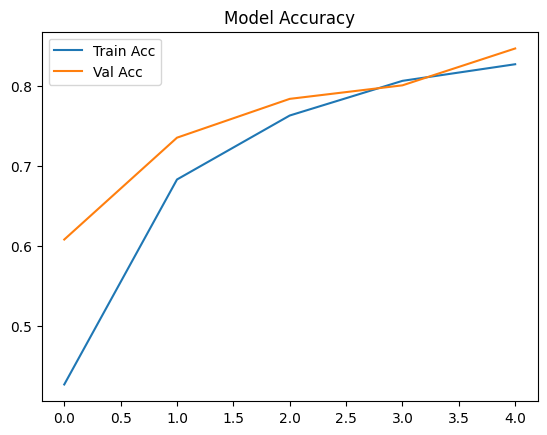

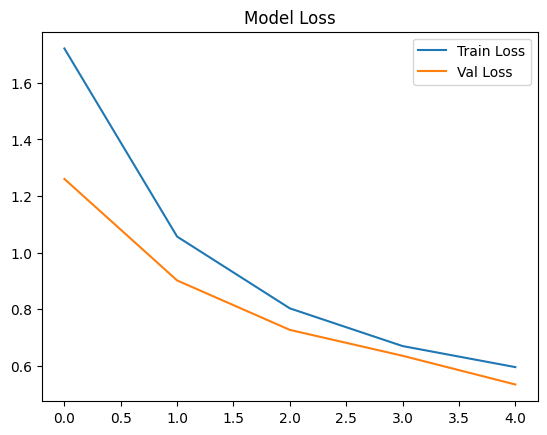

In [70]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


In [71]:
print("Final Training Accuracy:", history.history['accuracy'][-1])
print("Final Validation Accuracy:", history.history['val_accuracy'][-1])
print("Final Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])

Final Training Accuracy: 0.8275266289710999
Final Validation Accuracy: 0.8472687005996704
Final Training Loss: 0.5948851108551025
Final Validation Loss: 0.5334774851799011
